In [122]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, PrecisionRecallDisplay, auc, precision_recall_fscore_support, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import graphviz

In [123]:
## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [124]:
## Read Dataset
file_name = "Final Dataset.xlsx"
df = pd.read_excel(file_name, sheet_name = 0)

In [125]:
## Chop off extra space in some Vessel entries
df["VESSEL"] = df.VESSEL.str.replace(r"\b $", "", regex=True).str.strip()
## Convert time to float
df["TIME"] = df["TIME"].astype("str")
df["TIME"] = pd.to_datetime(df["TIME"])
df["TIME"] = df["TIME"].dt.hour+df["TIME"].dt.minute/60
## Replace target classes with 0, 1
di = {"NOT SERIOUS": 0, "SERIOUS": 1}
df = df.replace({"TARGET": di})
## Organize columns
cols = list(df.columns)
cols.remove("INJURY")
cols.remove("TARGET")
cols.remove("VESSEL")
class_weight = [df["TARGET"].value_counts()[0], df["TARGET"].value_counts()[1]]
## Split into train and validation set
row_idx = int(len(df.index)/5)
train_set = df[row_idx+1:]
test_set = df[:row_idx]
## Print class breakdown of train and validation set
print(train_set["TARGET"].value_counts())
print(test_set["TARGET"].value_counts())

0    5591
1      47
Name: TARGET, dtype: int64
0    1391
1      18
Name: TARGET, dtype: int64


In [126]:
## Initialize classifier and training set
X = train_set[cols]
y = train_set["TARGET"]

In [127]:
## K-folds CV
def kfolds(X, y, model, n_splits=4, cat_features=None):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X)
    max_acc = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        if acc > max_acc:
            max_acc = acc
            best_model = model
    return best_model

In [128]:
## Initialize classifiers
lgr = LogisticRegression(random_state=0, class_weight="balanced", max_iter=1000)
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", max_depth=3, criterion="entropy")

In [129]:
## Fit classifiers to data
best_lgr = kfolds(X, y, lgr)
best_clf = kfolds(X, y, clf)

In [130]:
## Print feature importance of logisitc regression model
weights = best_lgr.coef_[0]
for feature, weight in zip(cols, weights):
    print("FEATURE: %s, Importance: %.4f" % (feature, weight))

FEATURE: RANK, Importance: -0.0460
FEATURE: RATEG, Importance: 0.1582
FEATURE: AREA, Importance: 0.0197
FEATURE: TIME, Importance: 0.0547
FEATURE: DAY, Importance: 0.0272
FEATURE: MONTH, Importance: -0.0419
FEATURE: YEAR, Importance: -0.0007


In [131]:
## Get confusion matrix
def confusion_matrix(y_true, y_pred):
    metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print("PRECISION: %.2f%%" % (metrics[0]*100))
    print("RECALL: %.2f%%" % (metrics[1]*100))
    print("ACCURACY: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
    print("F-SCORE: %.2f%%" % (metrics[2]*100))

In [132]:
## Print classifier accuracy and show precision-recall curve
y_true = test_set["TARGET"]
y_pred = best_lgr.predict(test_set[cols])
print("===LOGISTIC REGRESSION MODEL===")
confusion_matrix(y_true, y_pred)

y_pred = best_clf.predict(test_set[cols])
print("===DECISION TREE MODEL===")
confusion_matrix(y_true, y_pred)

===LOGISTIC REGRESSION MODEL===
PRECISION: 97.92%
RECALL: 59.62%
ACCURACY: 59.62%
F-SCORE: 73.55%
===DECISION TREE MODEL===
PRECISION: 97.42%
RECALL: 84.17%
ACCURACY: 84.17%
F-SCORE: 90.25%


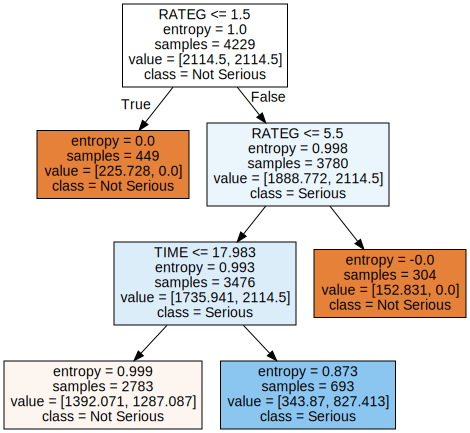

In [133]:
## Visualize tree
dot_data = tree.export_graphviz(best_clf, out_file=None, feature_names=cols, class_names=["Not Serious", "Serious"], filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [134]:
## Adjust features based on LR model
cols.remove("MONTH")
cols.remove("YEAR")
cols.remove("RATEG")
cols.remove("DAY")
X = train_set[cols]

In [135]:
## Initialize new tree classifier
reduced_clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", max_depth=3, criterion="entropy")

In [136]:
## Fit tree to reduced training set
reduced_clf = kfolds(X, y, reduced_clf)

In [137]:
## Print classifier accuracy and show precision-recall curve
y_true = test_set["TARGET"]
y_pred = reduced_clf.predict(test_set[cols])
print("===REDUCED DECISION TREE MODEL===")
confusion_matrix(y_true, y_pred)

===REDUCED DECISION TREE MODEL===
PRECISION: 96.93%
RECALL: 46.27%
ACCURACY: 46.27%
F-SCORE: 62.27%


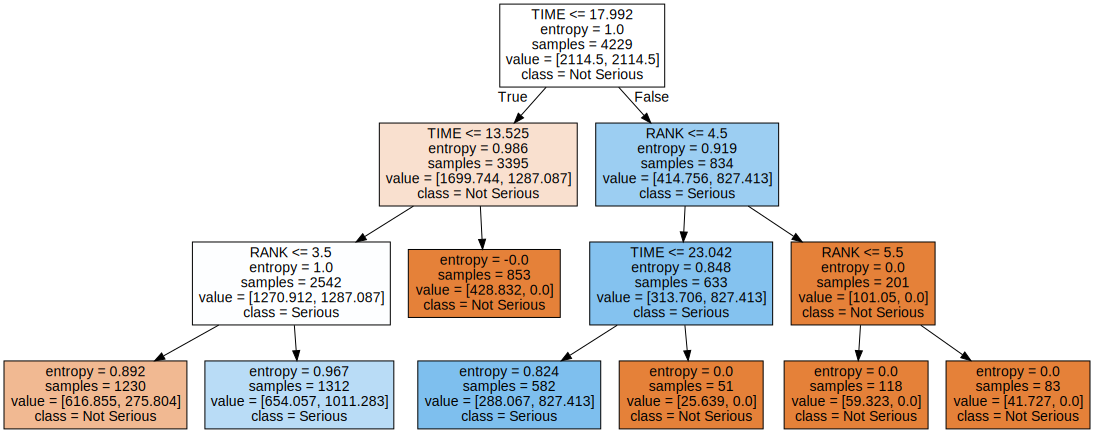

In [138]:
## Visualize reduced tree
dot_data = tree.export_graphviz(reduced_clf, out_file=None, feature_names=cols, class_names=["Not Serious", "Serious"], filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph